%%

LOG. 

July 4, 200. 
1. file loading path. 
2. KFold now is depreciated to model_selection module. 
3. KFold class now no longer have data argument. 
4. KFold substitutes n_splits for n_folds. 
6. (cont) instances of KFold take data as input. 
7. add feature_importances_ to class SklearnHelper. 
8. add isinstance to distinguish SVC from other emsemble methods.  
9. feature_importance_ plot for ensemble methods

TODO: 
1. pickle training result.
2. cross validation

source: https://www.kaggle.com/arthurtok/0-808-with-simple-stacking 

[Credits block of the original code] ----------------------------------------
Decided to try my hand at a very simple stacking script with 4 base models:
          - Random Forest, AdaBoost, Extra Trees & GradBoost
Script takes about a cool X min to run
This script was heavily influenced by Faron's Stacking starter in the Allstate
Severity Claims competition. [ Stacking Starter ] :
https://www.kaggle.com/mmueller/allstate-claims-severity/stacking-starter/run/390867
by Faron

Preprocessing was taken from Sina's very comprehensive and well-thought out
notebook on the best working classifier [ Titanic best working Classifier ] :
https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier by
Sina

More a very good read on Ensembling (Stacking/Blending), please check out
MLWave's brilliant Ensembling Guide
http://mlwave.com/kaggle-ensembling-guide/ 

In [1]:
import pandas as pd
import numpy as np
import re as re
from IPython.display import display
import xgboost as xgb
# Going to use these 4 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [2]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
PassengerId = test['PassengerId']

                                      PRE-PROCESSING                                             #

In [3]:
full_data = [train, test]
# Check distribution of PCLASS and number survived
display(train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())
# Check distribution of Sexes and number survived
display(train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, 
                                             age_avg + age_std, 
                                             size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 
        'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
# Encoding our features
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


,Sex,Survived
0,female,0.742038
1,male,0.188908


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
#drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp','Parch', 'FamilySize']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

%%

                                        STACKING                                                 #

In [5]:
ntrain = train.shape[0]
ntest = test.shape[0]
ncols = train.shape[1] - 1 # exclude the target feature
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits= NFOLDS, shuffle=True, random_state=SEED)

In [6]:
#%
# Write some Python helper functions that collects a lot of the SKlearn methods under one roof. 
# Totally ripped from Faron's Stacking starter ;)
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        if isinstance(self.clf, SVC):
            self.clf.fit(x_train, y_train)
        else:
            return self.clf.fit(x_train, y_train).feature_importances_ 

    def predict(self, x):
        return self.clf.predict(x)

In [7]:
def get_oof(helper, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    if not isinstance(helper.clf, SVC): 
        oof_fi = np.zeros((ncols,))
        oof_train_fi_skf = np.empty((NFOLDS, ncols)) # feature importance
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index] # training set X
        y_tr = y_train[train_index] # training set y
        x_te = x_train[test_index]  # validation set X
        if isinstance(helper.clf, SVC):
            helper.train(x_tr, y_tr)
        else:
            oof_train_fi_skf[i, :] = helper.train(x_tr, y_tr)
        oof_train[test_index] = helper.predict(x_te) # validation set prediction
        oof_test_skf[i, :] = helper.predict(x_test)  # test set prediction
    oof_test[:] = oof_test_skf.mean(axis=0) # average of test set prediction
    if isinstance(helper.clf, SVC):
        return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
    else:
        oof_fi[:] = oof_train_fi_skf.mean(axis=0)
        return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1), oof_fi.reshape(-1,1) # return validation set and test set prediction

In [8]:
# Assign the parameters for each of our 4 base models
rf_params = {
    'n_jobs': -1,
    'n_estimators': 575,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt'
    # 'verbose': 3 
}
et_params = {
    'n_jobs': -1,
    'n_estimators':575,
    #'max_features': 0.5,
    'max_depth': 5,
    'min_samples_leaf': 3
    # 'verbose': 3
}
ada_params = {
    'n_estimators': 575,
    'learning_rate' : 0.95
}
gb_params = {
    'n_estimators': 575,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 3
    # 'verbose': 3
}
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [9]:
# Create 4 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ad = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
sv = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [10]:
#%%
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # <---------------- important
x_test = test.values   # <---------------- important

In [11]:
#%
# Create our OOF train and test predictions. These `base` results will be used
# as new features
et_oof_train, et_oof_test, et_fi = get_oof(et, x_train, y_train, x_test)
rf_oof_train, rf_oof_test, rf_fi = get_oof(rf,x_train, y_train, x_test)
ad_oof_train, ad_oof_test, ad_fi = get_oof(ad, x_train, y_train, x_test)
gb_oof_train, gb_oof_test, gb_fi = get_oof(gb,x_train, y_train, x_test)
sv_oof_train, sv_oof_test = get_oof(sv, x_train, y_train, x_test)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


In [12]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ad_oof_train, gb_oof_train, sv_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ad_oof_test, gb_oof_test, sv_oof_test), axis=1)
print("{},{}".format(x_train.shape, x_test.shape))

(891, 5),(418, 5)


In [13]:
#%%
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
    'Random Forest feature importances': rf_fi.ravel(),
    'Extra Trees feature importances': et_fi.ravel(),
    'AdaBoost feature importances': ad_fi.ravel(),
    'Gradient Boost feature importances': gb_fi.ravel()
})

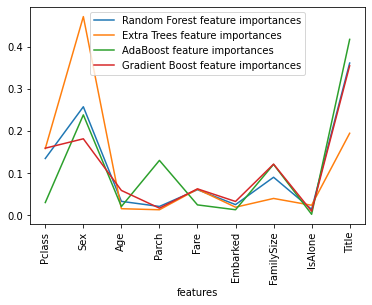

In [14]:
#%%
data = feature_dataframe.set_index('features')
data.plot(rot=90)

%%    

In [15]:
# Finally, we use an Xgboost classifier and feed it our oof train and test
# values as new features
gbm = xgb.XGBClassifier(learning_rate = 0.95,
                        n_estimators= 5000,
                        max_depth= 4,
                        min_child_weight= 2,
                        gamma=1,                        
                        subsample=0.8,
                        colsample_bytree=0.8,
                        objective= 'binary:logistic',
                        nthread= -1,
                        scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [16]:
#################################################################################################### 
#                           PRODUCING SUBMISSION FILE                                              #
#################################################################################################### 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                                    'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission1.csv", index=False)